# Experiment 3 - Multiple particle tracking comparison

## Introduction

The aim is to compare the performance of different ways of tracking multiple particles in a video/frame. The methods are:
* Tiled methods:
    - 'symmetry' method on overlapping tiles
    - DNN method on overlapping tiles
* Whole image methods:
    - train DNN on whole image and predict multiple particles
    - DNN segmentation followed by either symmetric dectection (on tiles) or further DNN

Interested in accuracy and speed (training and inference).

In [6]:
#hide
%load_ext autoreload
%autoreload 2

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal, uniform, choice, randint
from numpy import pi
import sys, shutil
from tqdm import tqdm
from deeptracktorch.disp import *
from deeptracktorch.simg import *
from deeptracktorch.measures import radialcenter
from deeptracktorch.models import DeepTrackNet
from deeptracktorch.video import track_single_particle, track_frame, show_tracked_frames

from fastai.vision import *
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [8]:
learner = load_learner('models/E1')

/Users/wooduk/projects/DeepTrack/venv/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.loss.MSELoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/wooduk/projects/DeepTrack/venv/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/wooduk/projects/DeepTrack/venv/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve th

In [9]:
video_file_name = '../../DeepTrack 1.0/DeepTrack - Example 3 - Brownian Particles.mp4'

estimators = {
        'deeptrack':lambda image: learner.predict(npimg2tensor(image))[1].numpy(),
        'symmetry':lambda image: np.array(radialcenter(image)[:3],dtype=np.float32),
    }

# predicted_positions = track_single_particle(
#     video_file_name, 
#     estimators,use_cv2=False)

import av
container = av.open(video_file_name)


number_frames_to_be_tracked = container.streams.video[0].frames

estimated_positions = {k:np.empty((number_frames_to_be_tracked,3)) for (k,v) in estimators.items()}

for i, frame in enumerate(container.decode(video=0)):
    image = frame.to_image().convert('L')
    image = np.array(image) / 255

    prediction_wrt_box, prediction_wrt_frame, boxes = track_frame(estimators['deeptrack'],image)
    break
    #

500 500
(90, 90, 51, 51)


In [69]:
prediction_wrt_frame.shape


(90, 90, 3)

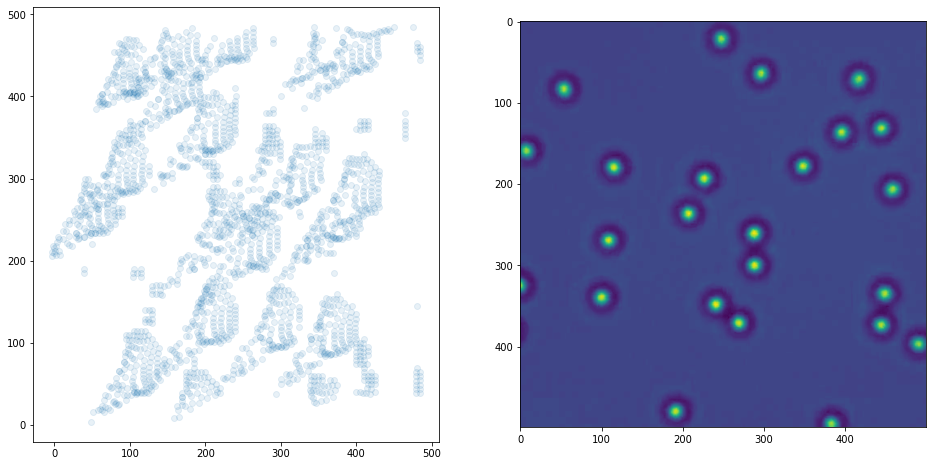

In [130]:
X=prediction_wrt_frame.reshape((90*90,3))
Y=X[np.array(X[:,2] < 15)]
f,ax=plt.subplots(1,2,figsize=(16,8))
#Y.shape
#ax.scatter(X[:,0],X[:,1], alpha=0.1)
ax[0].scatter(Y[:,0],Y[:,1], alpha=0.1)
ax[1].imshow(image)

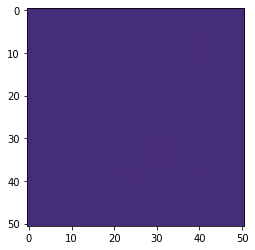

In [273]:
from itertools import product

def npimg2tensor(a):
    """Return the numpy array a, containing image data, as a torch tensor"""
    if a.ndim==2 : a = np.expand_dims(a,2)
    a = np.transpose(a, (1, 0, 2))
    a = np.transpose(a, (2, 1, 0))
    return torch.from_numpy(a.astype(np.float32))

img = np.array(frame.to_image().convert('L'))
#f,ax=plt.subplots(10,10,figsize=(14,14))
#ax=ax.flatten()
iwidth, iheight = img.shape
box_size = 51
a=0

X = [x for x in range(0, iwidth, box_size)]
Y = [x for x in range(0, iheight, box_size)]

padx=X[-1]+box_size-iwidth+1
pady=Y[-1]+box_size-iheight+1
img = np.pad(img, ((0,pady),(0,padx)), mode='median')
box_coords = np.array([[j[0],j[0]+box_size,j[1],j[1]+box_size] for j in product(X,Y)])

def predict_box(img, bx):
    a = npimg2tensor(img[bx[0]:bx[1], bx[2]:bx[3]])
    x,y,r = learner.predict(a)[1].numpy()
    plt.imshow(a[0,:,:],vmin=0,vmax=255)
    #plt.scatter(x=x,y=y)
    return ((x,y),(x+bx[0]+box_size/2,y+bx[2]+box_size/2))
                     
box_preds = np.array([predict_box(img, b) for b in box_coords])
frame_preds = box_preds[:,1]
#plt.scatter(x=frame_preds[:,0], y=frame_preds[:,1])
#plt.scatter(x=box_coords[:,0], y=box_coords[:,2])

#frame_preds = [box_preds
# for i in :
#     for j in range(0, iheight, box_size):
#         i1=min(i+box_size, iwidth)
#         j1=min(j+box_size, iheight)
#         box_content = ax[a].imshow(img[i:i1,j:j1],vmin=0, vmax=255)
#         ax[a].axis('off')
#         a+=1

In [11]:
import sklearn
dm2=sklearn.metrics.pairwise.euclidean_distances(X)
particle_maximum_interdistance = 15 


In [274]:
dm2


array([[  0.      ,   5.554326,  10.978446,  16.275195, ..., 619.16785 , 623.149919, 627.031402, 630.530593],
       [  5.554326,   0.      ,   5.424663,  10.722527, ..., 614.955878, 618.916938, 622.777827, 626.256821],
       [ 10.978446,   5.424663,   0.      ,   5.298436, ..., 610.934813, 614.874464, 618.714364, 622.172784],
       [ 16.275195,  10.722527,   5.298436,   0.      , ..., 607.103411, 611.021262, 614.83979 , 618.277269],
       ...,
       [619.16785 , 614.955878, 610.934813, 607.103411, ...,   0.      ,   5.363162,  10.635512,  15.61041 ],
       [623.149919, 618.916938, 614.874464, 611.021262, ...,   5.363162,   0.      ,   5.272655,  10.250277],
       [627.031402, 622.777827, 618.714364, 614.83979 , ...,  10.635512,   5.272655,   0.      ,   4.981385],
       [630.530593, 626.256821, 622.172784, 618.277269, ...,  15.61041 ,  10.250277,   4.981385,   0.      ]])

In [89]:
v = []
particle_number = 0

y = dm2 < particle_maximum_interdistance
z = np.ones_like(y)*-1
for i in range(8100):
    a = np.where(y[:,i])
    z[a[0],i]=i 
    

In [4]:
import numpy as np
a = [0,0,0,0,]
np.any(a)

False

In [46]:
def same_particle(p1,p2,rmin=15):
    #print(p1,p2)
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2) < rmin**2


# find the other observations that are the same particle (same_particle)
# average these positions and record the results
# remove all of these observations from the unlabelled list
# loop until all unlabelled observations gone.

unlabelled_observations = list([x for x in range(0,len(X))])
labelled_observations = np.ones(len(X))*-1

particle_number = -1
particle_positions = []


while len(unlabelled_observations) > 0:
    
    # Pick an observation from the unlabelled list (increment particle number)
    o = unlabelled_observations[0]
    particle_number=len(particle_positions)
    
    matching_observations = np.where([x for x in map(lambda x: same_particle(x,X[o]),X[unlabelled_observations])])
    #print(matching_observations[0])
    #print(X[matching_observations].mean(axis=0))
    # record average of matching positions
    particle_positions.append(X[matching_observations].mean(axis=0))
    
    # remove all of these observations from the unlabelled list
    unlabelled_observations=np.delete(unlabelled_observations,matching_observations[0])

    #print(len(matching_observations[0]),len(particle_positions),len(unlabelled_observations))
    


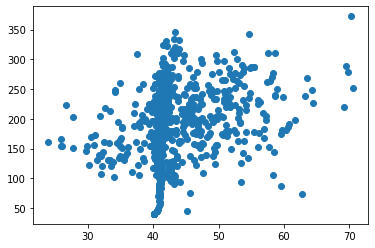

In [55]:
plt.scatter(np.array(particle_positions)[:,0],np.array(particle_positions)[:,1])

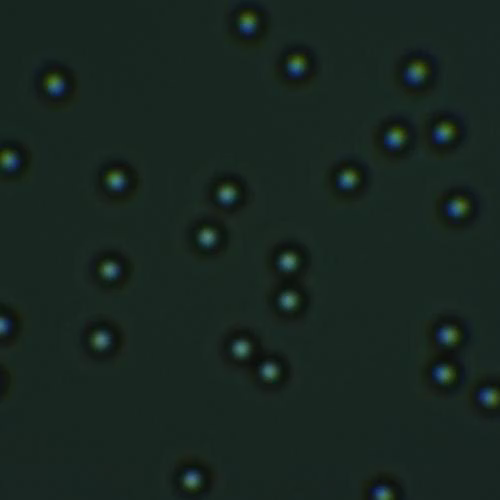

In [57]:
frame.to_image()

In [30]:
a=[x for x in range(0,10)]
a=np.delete(a,[5,6])
a

array([0, 1, 2, 3, 4, 7, 8, 9])

In [41]:
print(X[a])
X[a].mean(axis=0)

[[40.090157 40.090157]
 [40.619227 45.619227]
 [41.028434 51.028434]
 [45.343226 40.343226]
 [45.778685 45.778685]
 [46.097939 51.097939]
 [50.819632 40.819632]
 [51.134855 46.134855]]


array([45.114019, 45.114019])

In [35]:
X

array([[ 40.090157,  40.090157],
       [ 40.619227,  45.619227],
       [ 41.028434,  51.028434],
       [ 41.318902,  56.318902],
       ...,
       [485.343699, 470.343699],
       [485.695322, 475.695322],
       [485.961266, 480.961266],
       [485.942615, 485.942615]])

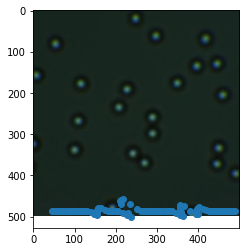

In [185]:
plt.imshow(frame.to_image())
plt.scatter(x=np.array(particles)[:,0], y=np.array(particles)[:,1])

In [ ]:
np.ndarray(1).flatten

In [ ]:
np.ndarray().flatten

In [ ]:
prediction_wrt_frame[:,:,:2].flatten

ValueError: attempt to get argmin of an empty sequence

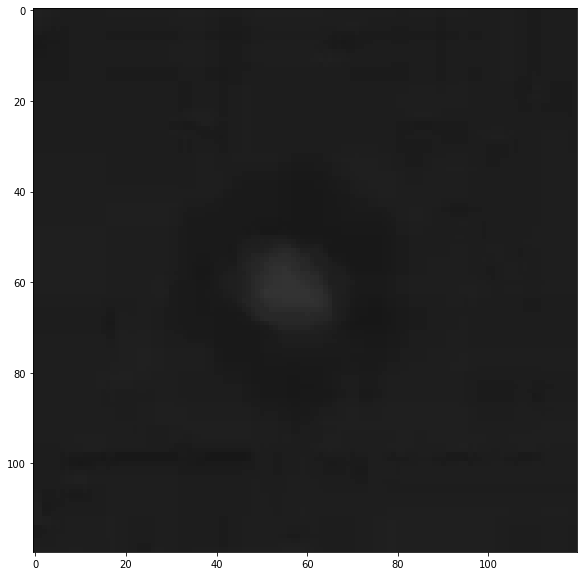

In [77]:
show_tracked_frames(
    particle_radial_distance_threshold=1.5,
    particle_maximum_interdistance=2,
    number_frames_to_be_shown=1,
    frames=[image],
    predicted_positions_wrt_frame=np.reshape(prediction_wrt_frame, (1,14,14,3)),
    )

In [276]:
prediction_wrt_frame[0,0]

array([40.090157, 40.090157, 15.090157])

In [277]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure()
ims=[]
J=[x for x in range(14)]
for i in range(14):
    for j in J:
        im = plt.imshow(boxes[i,j], vmin=0, vmax=255, animated=True)
        ims.append([im])
    J=[x for x in reversed(J)]

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# ani.save('dynamic_images.mp4')

HTML(ani.to_html5_video())

TypeError: list indices must be integers or slices, not tuple

<Figure size 432x288 with 0 Axes>